In [1]:
from templates import *
import matplotlib.pyplot as plt
import numpy as np
from math import acos, sin
import SimpleITK as sitk
from tqdm import tqdm
import sys

import torch
# GPU 설정 및 device 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

++++++++++!!!!+++++++++++
!!!!!USING 2ND MODEL??!!!!!!
!!!!!USING SEG E2E MODEL!!!!!!


/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/metrics.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
torch.cuda.is_available()

True

In [3]:
file_path = "/workspace/storage/kjh/dataset/cardiac/PNU_cardiac/CINE/test/middle_slice/sax/MR_Heart_148_crop_sa.nii.gz"
filling    = 8                             # 1장씩 보간
opt_idx    = 16                             # 최적화할 '보간 슬라이스'의 인덱스 (0부터 시작)
num_steps  = 200                           # x_t 최적화 스텝 수
lr         = 1e-2                          # x_t 학습률

t=30
isxTInt=False #Do we interpolated xT with slerp or just use the previous xT

In [4]:
k =0
conf = autoenc_base()
conf.img_size = 128
conf.net_ch = 128
conf.net_ch_mult = (1, 1, 2, 3, 4)
conf.net_enc_channel_mult = (1, 1, 2, 3, 4, 4)
conf.model_name = ModelName.beatgans_autoenc

conf.name = 'med256_autoenc'
conf.make_model_conf()

>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++


BeatGANsAutoencConfig(image_size=128, in_channels=1, model_channels=128, out_channels=1, num_res_blocks=2, num_input_res_blocks=None, embed_channels=512, attention_resolutions=(16,), time_embed_channels=None, dropout=0.1, channel_mult=(1, 1, 2, 3, 4), input_channel_mult=None, conv_resample=True, dims=2, num_classes=None, use_checkpoint=False, num_heads=1, num_head_channels=-1, num_heads_upsample=-1, resblock_updown=True, use_new_attention_order=False, resnet_two_cond=True, resnet_cond_channels=None, resnet_use_zero_module=True, attn_checkpoint=False, enc_out_channels=512, enc_attn_resolutions=None, enc_pool='adaptivenonzero', enc_num_res_block=2, enc_channel_mult=(1, 1, 2, 3, 4, 4), enc_grad_checkpoint=False, latent_net_conf=None)

In [5]:
model = LitModel(conf)
# breakpoint()
state = torch.load(f'/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_multi_PNU/checkpoints_multi/med256_autoenc/1/epoch=438-step=756789.ckpt', map_location=device)
model.load_state_dict(state['state_dict'], strict=True)
model.ema_model.eval()
model.ema_model.to(device)

Seed set to 0


>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
Model params: 122.58 M


/tmp/ipykernel_1622608/1543032759.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_multi_PNU/c

BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias

Load SAX

In [6]:
import ants

# 2. 전처리 함수 (bias + clipping)
def preprocess_n4_clip(arr, low_pct=1, high_pct=98):
    img_ants = ants.from_numpy(arr)
    arr_n4   = ants.n4_bias_field_correction(img_ants).numpy()
    lo, hi   = np.percentile(arr_n4, [low_pct, high_pct])
    return np.clip(arr_n4, lo, hi)

In [7]:
# 3) NIfTI 로드 → numpy (Z,H,W)
img_itk = sitk.ReadImage(file_path)
vol_np  = sitk.GetArrayFromImage(img_itk)

# 4) intensity normalize
# mx = np.percentile(vol_np, 98)
# vol_np = np.clip(vol_np, 0, mx) / mx
vol_np = preprocess_n4_clip(vol_np)
vol_np = vol_np / np.max(vol_np)
vol_np = vol_np * 2.0 - 1.0

print("flip!!!!!")
vol_np = np.flip(vol_np, axis=-2).copy()



flip!!!!!


In [8]:
vol_np.min(), vol_np.max()

(-1.0, 1.0)

In [9]:
print("vol_np nan/inf:", np.isnan(vol_np).any(), np.isinf(vol_np).any())


vol_np nan/inf: False False


일단 Frame은 0으로

In [10]:
frame = 0

In [11]:
vol_np = vol_np[frame,:,:,:]

# 빈 슬라이스(모두 0) 제거
nonzero_idx = [i for i in range(len(vol_np)) if vol_np[i].max() != 0]
vol_nz      = vol_np[nonzero_idx]


Load LAX and Mask

In [12]:
# 1) NumPy 로드 및 NaN 처리
gt_np = sitk.GetArrayFromImage(
    sitk.ReadImage(f"/workspace/storage/icml_data_collection/Cardiac_database/PNUH/PNUH_cine_LAX_SAX_align_2/MR_Heart_148/combine_1lax_cropped/combine_1lax_cropped_{frame}.nii.gz")
).astype(np.float32)


mask = sitk.GetArrayFromImage(
    sitk.ReadImage(f"/workspace/storage/icml_data_collection/Cardiac_database/PNUH/PNUH_cine_LAX_SAX_align_2/MR_Heart_148/combine_1lax_mask_cropped_adjusted/combine_1lax_mask_cropped_adjusted_{frame}.nii.gz")
).astype(np.float32)

# 2) 정규화 기준값 계산 (NaN 무시)
gt_np = preprocess_n4_clip(gt_np)


gt_np = np.flip(gt_np, axis=-2).copy()

mask = np.flip(mask, axis=-2).copy()

In [13]:
mask.shape

(73, 128, 128)

In [ ]:
def inter_sax_load(file_path) :
    img_itk_inter = sitk.ReadImage(file_path)
    vol_np_inter  = sitk.GetArrayFromImage(img_itk_inter)

    # 4) intensity normalize
    # mx = np.percentile(vol_np, 98)
    # vol_np = np.clip(vol_np, 0, mx) / mx
    vol_np_inter = preprocess_n4_clip(vol_np_inter)
    vol_np_inter = vol_np_inter / np.max(vol_np_inter)

    print("flip!!!!!")
    vol_np_inter = np.flip(vol_np_inter, axis=-2).copy()

    # 빈 슬라이스(모두 0) 제거
    nonzero_idx = [i for i in range(len(vol_np_inter)) if vol_np_inter[i].max() != 0]
    vol_nz_inter      = vol_np_inter[nonzero_idx]
    return vol_nz_inter

In [15]:
# 3. Quantile‐mapping 헬퍼
def make_quantile_map(src_vals, tgt_vals, n_quant=101):
    qs    = np.linspace(0, 1, n_quant)
    src_q = np.quantile(src_vals, qs)
    tgt_q = np.quantile(tgt_vals, qs)
    return src_q, tgt_q

sax_idx, _, _ = vol_nz.shape


linear_sax = inter_sax_load(f"/workspace/storage/icml_data_collection/Cardiac_database/PNUH/PNUH_cine_LAX_SAX_align_2/MR_Heart_148/sax_resample_linear_cropped/sax_resample_linear_cropped_{frame}.nii.gz")

# B) i*8번째 slice에서만 분포 추출 → quantile map
sax_vals, comb_vals = [], []
for z in range(sax_idx):
    print(z)
    sax_vals .append(linear_sax[:, :, z*8][mask[:, :, z*8]>0])
    comb_vals.append(gt_np[:, :, z*8][mask[:, :, z*8]>0])
src_q, tgt_q = make_quantile_map(np.concatenate(comb_vals),
                                 np.concatenate(sax_vals), n_quant=101)
# C) combine_data 전체 정규화
flat_in      = gt_np.flatten()
gt_norm = np.interp(flat_in, src_q, tgt_q).reshape(gt_np.shape)

flip!!!!!
0
1
2
3
4
5
6
7
8
9


In [25]:
gt_norm.min(), gt_norm.max()

(9.030640602111816, 808.0512084960938)

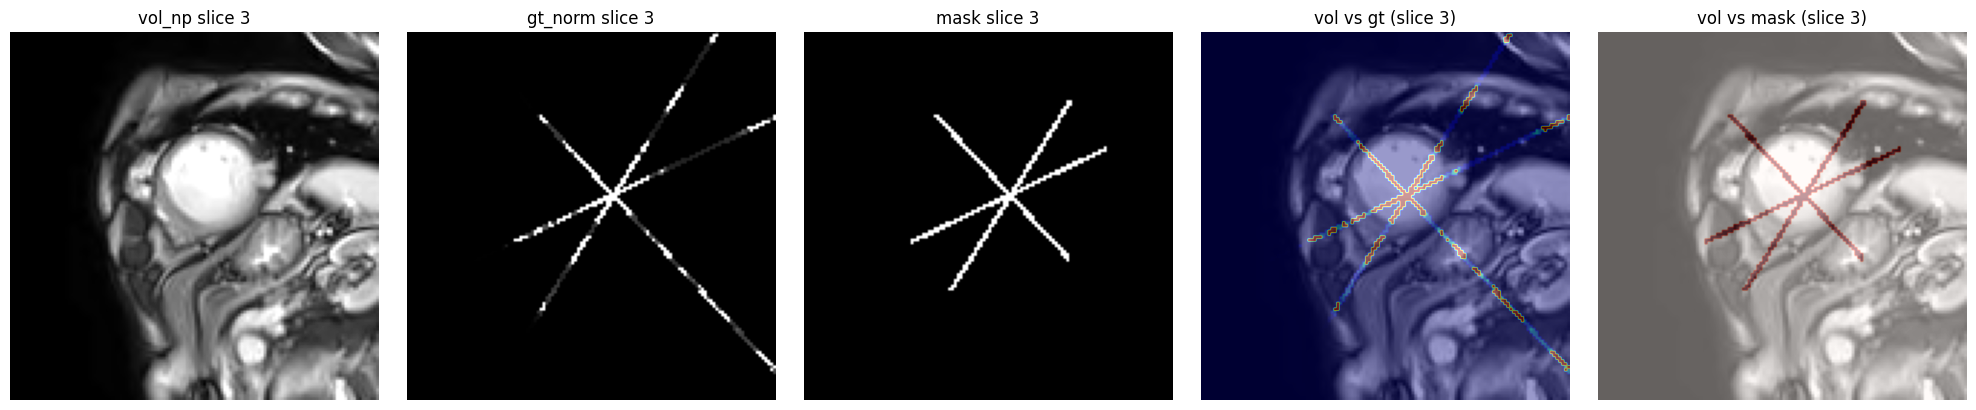

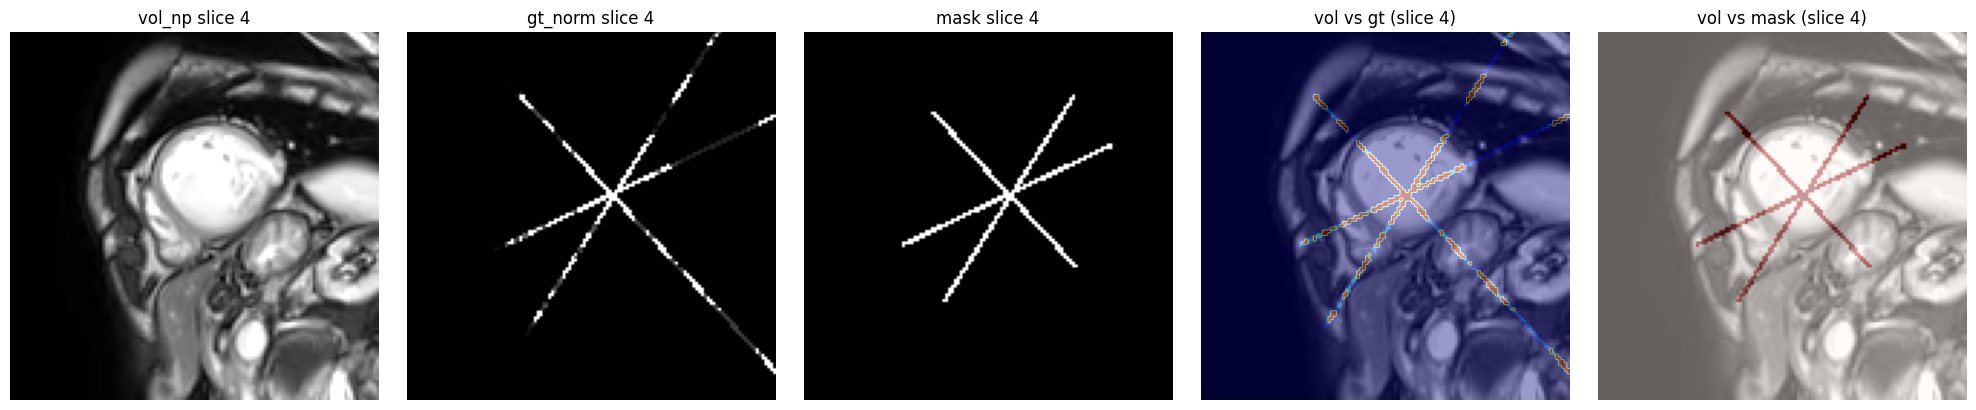

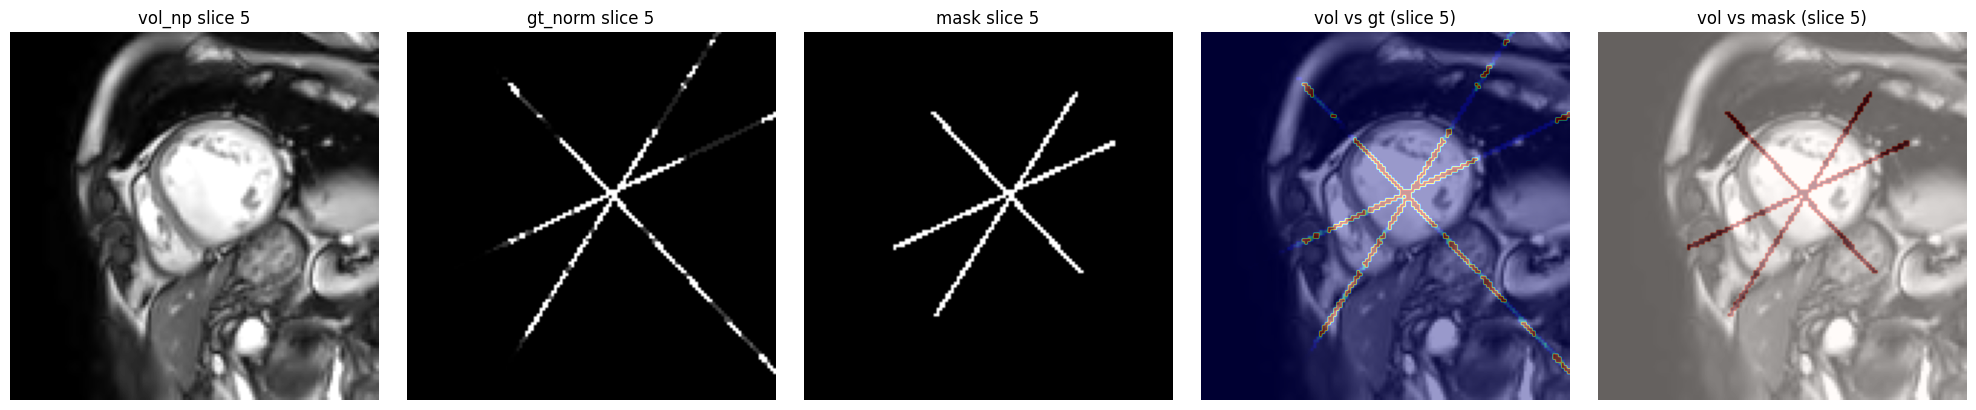

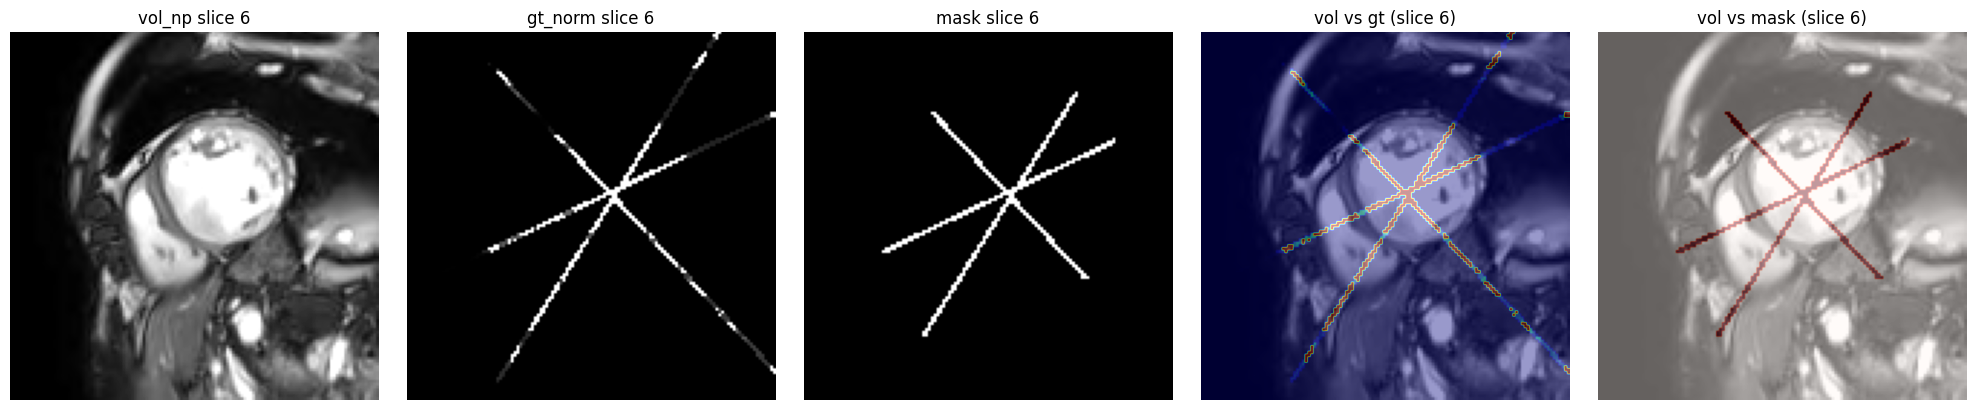

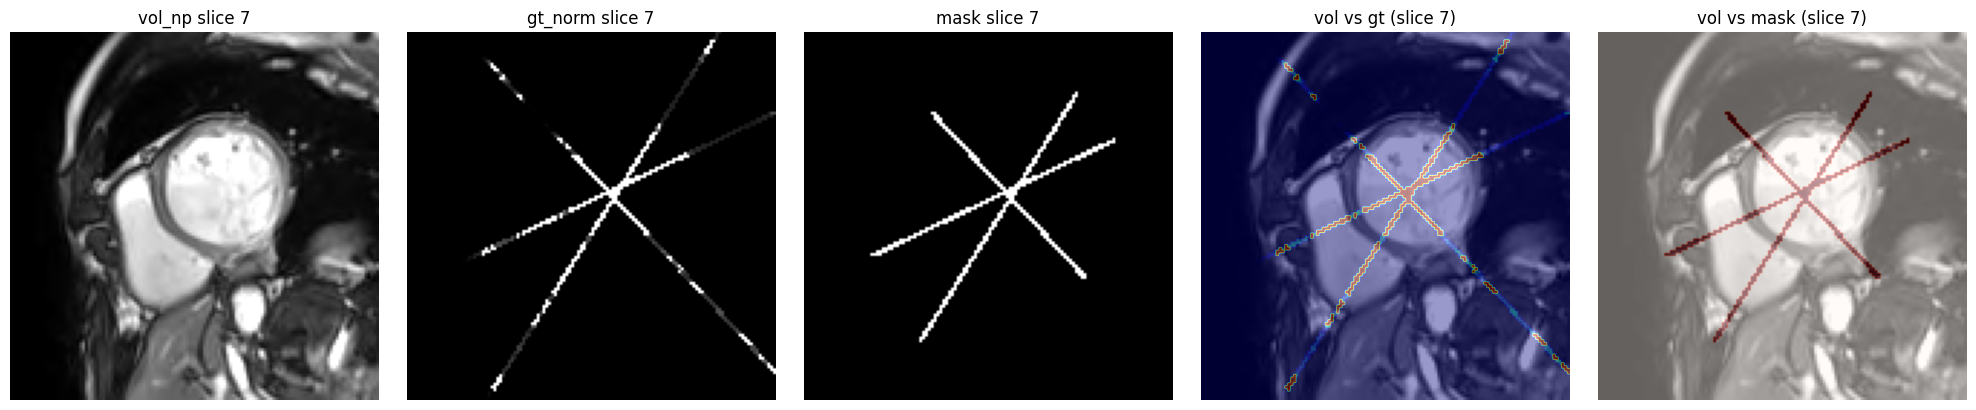

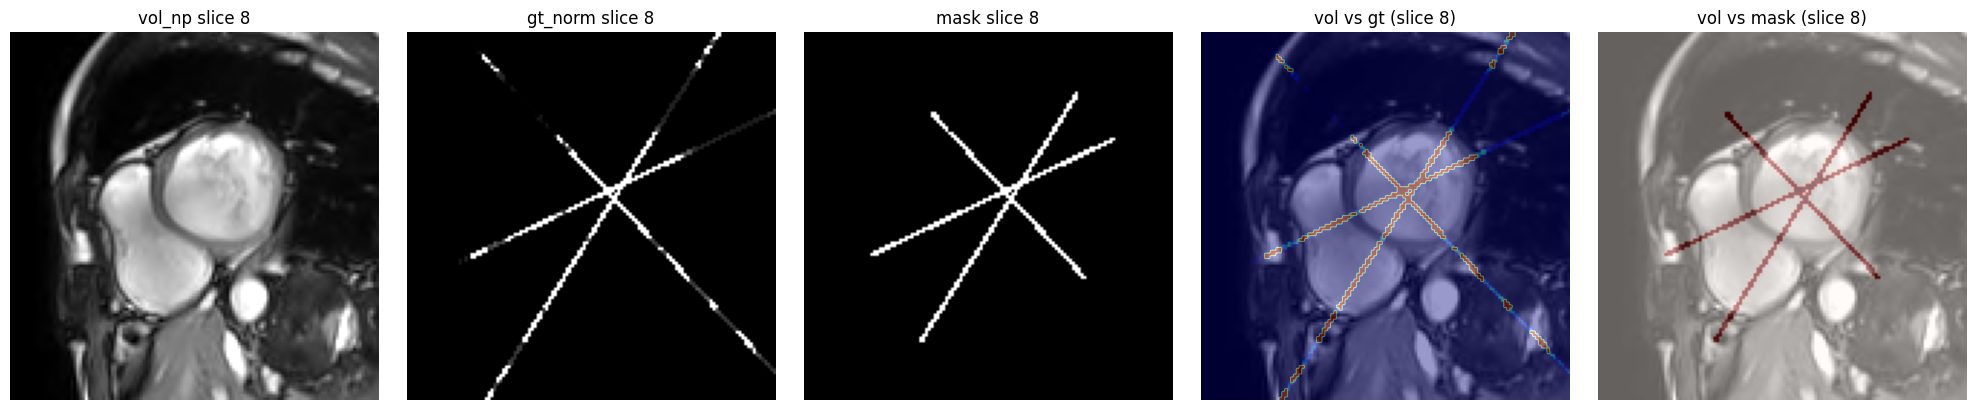

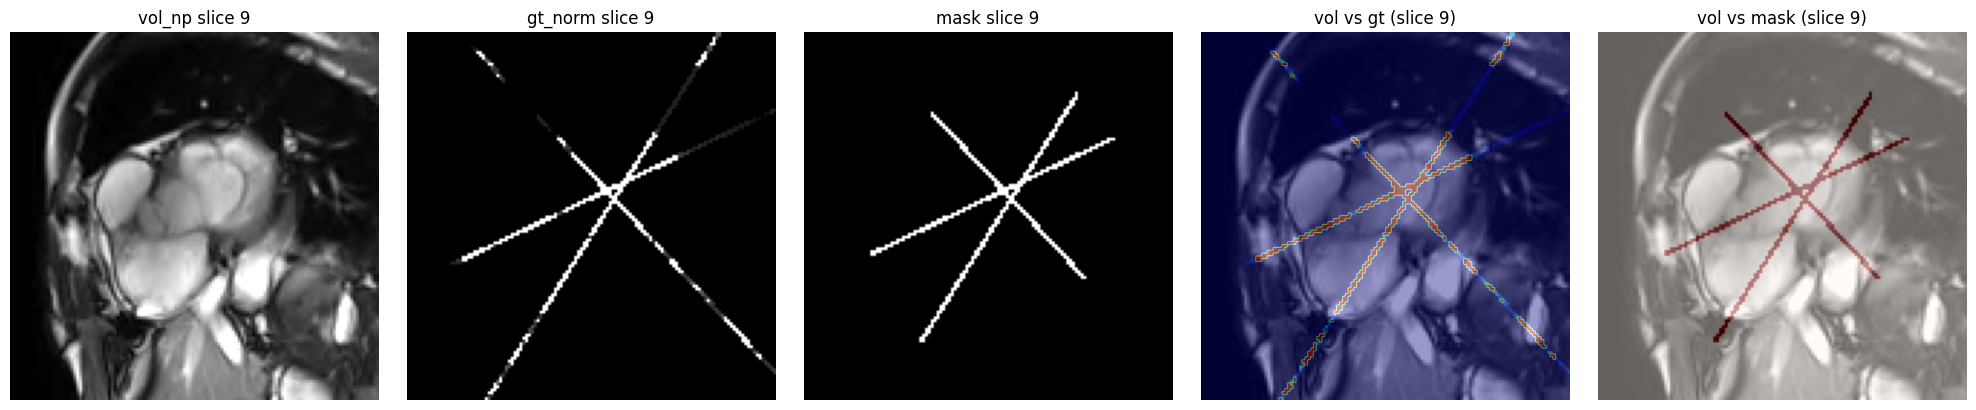

In [16]:
# 확인

import matplotlib.pyplot as plt
import numpy as np

# 이미 로드된 3개의 3D numpy 배열: vol_np, gt_np, mask
# vol_np: shape (Z, H, W), gt_np: shape (Z, H, W), mask: shape (Z, H, W)

# 3~9번 슬라이스(0-based index) 시각화
slice_indices = list(range(3, 10))  # 3, 4, 5, 6, 7, 8, 9

for idx in slice_indices:
    idx_ = 8 * (idx - 1) + 1
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # 1) vol_np 원본
    axes[0].imshow(vol_np[idx], cmap='gray')
    axes[0].set_title(f'vol_np slice {idx}')
    axes[0].axis('off')

    # 2) gt_np 원본
    axes[1].imshow(gt_norm[idx_], cmap='gray')
    axes[1].set_title(f'gt_norm slice {idx}')
    axes[1].axis('off')

    # 3) mask 원본
    axes[2].imshow(mask[idx_], cmap='gray')
    axes[2].set_title(f'mask slice {idx}')
    axes[2].axis('off')

    # 4) vol_np + gt_np Overlay
    axes[3].imshow(vol_np[idx], cmap='gray')
    axes[3].imshow(gt_norm[idx_], cmap='jet', alpha=0.4)
    axes[3].set_title(f'vol vs gt (slice {idx})')
    axes[3].axis('off')

    # 5) vol_np + mask Overlay
    axes[4].imshow(vol_np[idx], cmap='gray')
    axes[4].imshow(mask[idx_], cmap='Reds', alpha=0.4)
    axes[4].set_title(f'vol vs mask (slice {idx})')
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# # --- Step 2: 1이 있는 영역의 중심 계산 ---
# z = 16

# mask_1 = mask

# slice_ = mask_1[z, :, :]  # shape: (H, W)


# # --- Step 3: 마스크 중심 찾기 ---
# ys, xs = np.where(slice_ == 1)
# if len(xs) == 0 or len(ys) == 0:
#     raise ValueError("마스크에 1인 값이 없습니다.")

# cx = int(np.mean(xs))
# cy = int(np.mean(ys))

# # --- Step 4: 중심 기준으로 80x80 박스 좌표 계산 ---
# crop_size = 70
# half = crop_size // 2

# x1 = max(cx - half, 0)
# x2 = min(cx + half, slice_.shape[1])
# y1 = max(cy - half, 0)
# y2 = min(cy + half, slice_.shape[0])

# # --- Step 5: 마스크 초기화 후 crop 영역만 유지 ---
# new_slice = np.zeros_like(slice_)
# new_slice[y1:y2, x1:x2-10] = slice_[y1:y2, x1:x2-10]

# # --- Step 6: 결과 적용 ---
# mask_1[z] = new_slice

# print(f"✔ 중심 좌표: ({cy}, {cx})")
# print(f"✔ crop 영역: x=({x1}, {x2}), y=({y1}, {y2})")
# print(f"✔ 결과 마스크 shape: {mask_1.shape}")

In [ ]:
# # crop 확인
# import matplotlib.pyplot as plt
# import numpy as np

# idx = 2
# idx_ = 8 * idx
# fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# # 1) vol_np 원본
# axes[0].imshow(mask[idx_], cmap='gray')
# axes[0].set_title(f'vol_np slice {idx}')
# axes[0].axis('off')

# # 2) gt_np 원본
# axes[1].imshow(gt_np[idx_], cmap='gray')
# axes[1].set_title(f'gt_np slice {idx}')
# axes[1].axis('off')

# # 3) mask 원본
# axes[2].imshow(mask_1[idx_], cmap='gray')
# axes[2].set_title(f'mask slice {idx}')
# axes[2].axis('off')

# # 4) vol_np + gt_np Overlay
# axes[3].imshow(vol_np[idx], cmap='gray')
# axes[3].imshow(gt_np[idx_], cmap='jet', alpha=0.4)
# axes[3].set_title(f'vol vs gt (slice {idx})')
# axes[3].axis('off')

# # 5) vol_np + mask Overlay
# axes[4].imshow(vol_np[idx], cmap='gray')
# axes[4].imshow(mask_1[idx_], cmap='Reds', alpha=0.4)
# axes[4].set_title(f'vol vs mask (slice {idx})')
# axes[4].axis('off')
# plt.tight_layout()
# plt.show()

In [17]:
fname = os.path.basename(file_path)
subject_id = int(fname.split('_')[2])
print(subject_id)
# if subject_id >= 665:
#     vol_np = np.flip(vol_np, axis=-2).copy()

148


In [18]:
# 선형 보간 l_sem
def lin_interpolate(slice_1,slice_2,num=filling):
    #num is how many slices need to be inserted
    alpha=1.0/(num-1.0)
    out=[]
    # out.append(slice_1)
    for i in range(num-1):
        out.append((i)*alpha*slice_2+(1.0-(i)*alpha)*slice_1)
    # out.append(slice_2)
    return out

def slerp(x0: torch.Tensor, x1: torch.Tensor, alpha: float) -> torch.Tensor:
    """Spherical Linear intERPolation
    Args:
        x0 (`torch.Tensor`): first tensor to interpolate between
        x1 (`torch.Tensor`): seconds tensor to interpolate between
        alpha (`float`): interpolation between 0 and 1
    Returns:
        `torch.Tensor`: interpolated tensor
    """

    theta = acos(torch.dot(torch.flatten(x0), torch.flatten(x1)) / torch.norm(x0) / torch.norm(x1))
    return sin((1 - alpha) * theta) * x0 / sin(theta) + sin(alpha * theta) * x1 / sin(theta)

def slerp_np(x0: np.ndarray, x1: np.ndarray, alpha: float) -> np.ndarray:
    """Spherical Linear intERPolation
    Args:
        x0 (`torch.Tensor`): first tensor to interpolate between
        x1 (`torch.Tensor`): seconds tensor to interpolate between
        alpha (`float`): interpolation between 0 and 1
    Returns:
        `torch.Tensor`: interpolated tensor
    """

    theta = acos(np.dot(x0.flatten(), x1.flatten()) / np.linalg.norm(x0) / np.linalg.norm(x1))
    return sin((1 - alpha) * theta) * x0 / sin(theta) + sin(alpha * theta) * x1 / sin(theta)

# 구형 보간 - X_t
def slerp_interpolate(slice_1,slice_2,num=filling):
    #num is how many slices need to be inserted
    alpha=1.0/(num-1)
    out=[]
    # out.append(slice_1)
    for i in range(num-1):
        out.append(slerp_np(slice_1,slice_2,alpha*i))
    # out.append(slice_2)
    return out

In [19]:
t

30

In [20]:
# 7) Torch tensor 변환 & 모델 인코딩
img_tensor  = torch.from_numpy(vol_nz).float().unsqueeze(1).to(device)  
cond_tensor = model.encode(img_tensor)                                
xTs         = model.encode_stochastic(img_tensor, cond_tensor, T=t)       # x_0를 DDIM reverse sampling을 이용해 최종 noise 레벨 x_t (latent) 까지 역변환하고, 그 결과 (deterministic)

# 8) 보간(interpolation)
xTs_np  = xTs.cpu().numpy()
cond_np = cond_tensor.cpu().numpy()
final_x, final_c = [], []
for i in range(xTs_np.shape[0]-1):
    final_x.append(xTs_np[i]); final_c.append(cond_np[i])
    mid_x = slerp_interpolate(xTs_np[i], xTs_np[i+1], num=filling)
    mid_c = lin_interpolate(cond_np[i],  cond_np[i+1],  num=filling)
    final_x.extend(mid_x); final_c.extend(mid_c)
final_x.append(xTs_np[-1]); final_c.append(cond_np[-1])

interp_xTs   = torch.from_numpy(np.stack(final_x)).float().to(device)
interp_conds = torch.from_numpy(np.stack(final_c)).float().to(device)

/usr/local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.8/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/diffusion/base.py:406: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(self.conf.fp16):


In [21]:
img_tensor.shape, xTs.shape, cond_tensor.shape

(torch.Size([10, 1, 128, 128]),
 torch.Size([10, 1, 128, 128]),
 torch.Size([10, 512]))

In [22]:
print("x_t_slice nan/inf:", torch.isnan(img_tensor).any(), torch.isinf(img_tensor).any())
print("x_t_slice nan/inf:", torch.isnan(xTs).any(), torch.isinf(xTs).any())
print("cond_slice nan/inf:", torch.isnan(cond_tensor).any(), torch.isinf(cond_tensor).any())


x_t_slice nan/inf: tensor(False, device='cuda:0') tensor(False, device='cuda:0')
x_t_slice nan/inf: tensor(False, device='cuda:0') tensor(False, device='cuda:0')
cond_slice nan/inf: tensor(False, device='cuda:0') tensor(False, device='cuda:0')


original data - pred data 의 ssim, psnr

In [ ]:
# from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# # vol_nz : -1~1
# # pred : 0~1
# z, y, x = vol_nz.shape
# for i in range(z):
#     pred_metric = model.render(xTs[i:i+1], cond=cond_tensor[i:i+1], T=t)

#     vol_compare = (vol_nz + 1) / 2
#     pred_metric = pred_metric.squeeze(0).squeeze(0).detach().cpu().numpy()
#     ssim_val_ = ssim(vol_compare[i, :, :], pred_metric, data_range=1.0)
#     psnr_val_ = psnr(vol_compare[i, :, :], pred_metric, data_range=1.0)

#     print(f"{i}, ssim: {ssim_val_}, psnr: {psnr_val_}")

EX) 총 65slice를 가질 때 original 은 [1, 1+7+1, 9+7+1, ..]

[1, 9, 17, 25, 33, 41, 49, 57, 65]

=> slice 순서 + (ori_slice_num + 1)

일단 1, 9 사이로 하겠음

In [23]:
# 4) Torch 텐서로 변환
region_gt = torch.tensor(gt_norm, dtype=torch.float32).to(device)      # 65, 128, 128
region_mask = torch.tensor(mask, dtype=torch.float32).to(device)     # 65, 128, 128

In [ ]:
# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn

# # --- 하이퍼파라미터 ---
# num_epochs    = 200
# num_steps     = 1
# base_lr       = 2e-3
# lambda_roi    = 5.0
# lambda_latent = 0.02
# alpha_proj    = 0.001

# # --- 디바이스 및 텐서 초기화 ---
# device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice      = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice     = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init = x_t_slice.detach().clone()
# cond_slice_init= cond_slice.detach().clone()
# gt             = region_gt[opt_idx:opt_idx+1].unsqueeze(0).to(device)
# # gt             = region_nz[2:3].unsqueeze(0).to(device)

# # --- LAX & ROI mask ---
# region_mask = region_mask[opt_idx:opt_idx+1].unsqueeze(0)
# n_valid     = region_mask.sum().float()
# gt_roi      = gt * region_mask
# mu_gt       = gt_roi.sum() / n_valid
# sigma_gt    = torch.sqrt(((gt_roi - mu_gt) * region_mask).pow(2).sum() / n_valid + 1e-6)

# # --- Optimizer & Scheduler ---
# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# # --- Gradient hook 등록 ---
# def print_grad(name):
#     def hook(grad):
#         print(f"{name}.grad norm = {grad.norm().item():.6f}")
#     return hook

# x_t_slice.register_hook(print_grad("x_t_slice"))
# cond_slice.register_hook(print_grad("cond_slice"))

# # --- 실시간 그래프 세팅 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- 최적화 루프 ---
# for epoch in range(num_epochs):
#     for step in range(num_steps):
#         # 1) Forward
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)

#         # 2) Pred ROI 통계 업데이트
#         pred_roi   = pred * region_mask
        
#         mu_pred    = pred_roi.sum() / n_valid
#         sigma_pred = torch.sqrt(((pred_roi - mu_pred) * region_mask).pow(2).sum() / n_valid + 1e-6)
#         sigma_pred = torch.clamp(sigma_pred, min=1e-3)

#         # 3) Affine normalization
#         pred_norm     = (pred - mu_pred) * (sigma_gt / sigma_pred) + mu_gt
#         pred_norm_roi = pred_norm * region_mask

#         # 4) ROI-only MSE loss -> 그래서 sum을 사용
#         roi_loss   = F.mse_loss(pred_norm_roi, gt_roi, reduction='sum') / n_valid

#         # 5) Latent prior loss
#         latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
#         cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
#         prior_loss = lambda_latent * (latent_reg + cond_reg)

#         # 6) Total loss
#         loss = lambda_roi * roi_loss + prior_loss

#         # 7) Backward & Update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # 8) Projection
#         with torch.no_grad():
#             x_t_slice.data  = (1 - alpha_proj) * x_t_slice.data  + alpha_proj * x_t_slice_init
#             cond_slice.data = (1 - alpha_proj) * cond_slice.data + alpha_proj * cond_slice_init

#         # 9) Logging & Plot
#         loss_history.append(loss.item())
#         line.set_xdata(range(len(loss_history)))
#         line.set_ydata(loss_history)
#         ax.relim(); ax.autoscale_view()
#         fig.canvas.draw(); fig.canvas.flush_events()
#         print(f"[E{epoch+1}S{step+1}] loss={loss.item():.6f} "
#               f"(roi={roi_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     scheduler.step()

# print("Optimization 완료")


In [ ]:
# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn

# # --- 하이퍼파라미터 ---
# num_epochs    = 200
# num_steps     = 1
# base_lr       = 2e-3
# lambda_roi    = 5.0
# lambda_latent = 0.02
# alpha_proj    = 0.001

# lambda_mu  = 0.1
# lambda_sig = 0.1

# # --- 디바이스 및 텐서 초기화 ---
# device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice      = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice     = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init = x_t_slice.detach().clone()
# cond_slice_init= cond_slice.detach().clone()
# gt             = region_gt[opt_idx:opt_idx+1].unsqueeze(0).to(device)
# # gt             = region_nz[2:3].unsqueeze(0).to(device)

# # --- LAX & ROI mask ---
# region_mask = region_mask[opt_idx:opt_idx+1].unsqueeze(0)
# n_valid     = region_mask.sum().float()
# gt_roi      = gt * region_mask
# mu_gt       = gt_roi.sum() / n_valid
# sigma_gt    = torch.sqrt(((gt_roi - mu_gt) * region_mask).pow(2).sum() / n_valid + 1e-6)

# # --- Optimizer & Scheduler ---
# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# # --- Gradient hook 등록 ---
# def print_grad(name):
#     def hook(grad):
#         print(f"{name}.grad norm = {grad.norm().item():.6f}")
#     return hook

# x_t_slice.register_hook(print_grad("x_t_slice"))
# cond_slice.register_hook(print_grad("cond_slice"))

# # --- 실시간 그래프 세팅 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- 최적화 루프 ---
# for epoch in range(num_epochs):
#     for step in range(num_steps):
#         # 1) Forward
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)

#         # 2) Pred ROI 통계 업데이트
#         pred_roi   = pred * region_mask
        
#         mu_pred    = pred_roi.sum() / n_valid
#         sigma_pred = torch.sqrt(((pred_roi - mu_pred) * region_mask).pow(2).sum() / n_valid + 1e-6)
#         sigma_pred = torch.clamp(sigma_pred, min=1e-3)

#         # 3) MSE LOSS 
#         roi_loss = F.mse_loss(pred_roi, gt_roi, reduction='sum') / n_valid

#         # 5) Latent prior loss
#         latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
#         cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
#         prior_loss = lambda_latent * (latent_reg + cond_reg)

#         # 6) Mean/std penalty loss
#         loss_mu  = F.l1_loss(mu_pred, mu_gt)      # μ_pred ≈ μ_gt
#         loss_sig = F.l1_loss(sigma_pred, sigma_gt)  # σ_pred ≈ σ_gt

#         # 7) Total loss (hybrid)
#         loss = (lambda_roi * roi_loss
#                 + prior_loss
#                 + lambda_mu * loss_mu
#                 + lambda_sig * loss_sig)

#         # 7) Backward & Update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # 8) Projection
#         with torch.no_grad():
#             x_t_slice.data  = (1 - alpha_proj) * x_t_slice.data  + alpha_proj * x_t_slice_init
#             cond_slice.data = (1 - alpha_proj) * cond_slice.data + alpha_proj * cond_slice_init

#         # 9) Logging & Plot
#         loss_history.append(loss.item())
#         line.set_xdata(range(len(loss_history)))
#         line.set_ydata(loss_history)
#         ax.relim(); ax.autoscale_view()
#         fig.canvas.draw(); fig.canvas.flush_events()
#         print(f"[E{epoch+1}S{step+1}] loss={loss.item():.6f} "
#               f"(roi={roi_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     scheduler.step()

# print("Optimization 완료")


/usr/local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/diffusion/base.py:406: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(self.conf.fp16):
/usr/local/lib/python3.8/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` i

x_t_slice.grad norm = 88.222549
cond_slice.grad norm = 1333.058594
[E1S1] loss=2104905.000000 (roi=420981.000000, prior=0.000000)
x_t_slice.grad norm = 90.232262
cond_slice.grad norm = 1380.099731
[E2S1] loss=2104850.000000 (roi=420970.000000, prior=0.000000)
x_t_slice.grad norm = 86.189423
cond_slice.grad norm = 1291.789062
[E3S1] loss=2104796.750000 (roi=420959.343750, prior=0.000001)
x_t_slice.grad norm = 83.116005
cond_slice.grad norm = 1215.704834
[E4S1] loss=2104746.750000 (roi=420949.343750, prior=0.000001)
x_t_slice.grad norm = 76.720581
cond_slice.grad norm = 1081.867676
[E5S1] loss=2104701.000000 (roi=420940.187500, prior=0.000002)
x_t_slice.grad norm = 75.641212
cond_slice.grad norm = 1061.175903
[E6S1] loss=2104659.000000 (roi=420931.781250, prior=0.000003)
x_t_slice.grad norm = 74.923592
cond_slice.grad norm = 1046.122070
[E7S1] loss=2104617.750000 (roi=420923.562500, prior=0.000005)
x_t_slice.grad norm = 74.087784
cond_slice.grad norm = 1024.075439
[E8S1] loss=2104577.500

KeyboardInterrupt: 

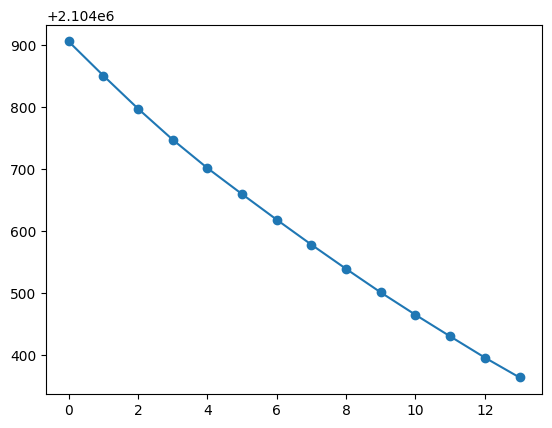

In [24]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn

# --- 하이퍼파라미터 ---
num_epochs    = 200
num_steps     = 1
base_lr       = 2e-3
lambda_roi    = 5.0
lambda_latent = 0.02
alpha_proj    = 0.001

# --- 디바이스 및 텐서 초기화 ---
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_t_slice      = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
cond_slice     = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
x_t_slice_init = x_t_slice.detach().clone()
cond_slice_init= cond_slice.detach().clone()
gt             = region_gt[opt_idx:opt_idx+1].unsqueeze(0).to(device)
# gt             = region_nz[2:3].unsqueeze(0).to(device)

# --- LAX & ROI mask ---
region_mask = region_mask[opt_idx:opt_idx+1].unsqueeze(0).to(device)

mask_bool  = region_mask.bool()
n_valid     = region_mask.sum().float()
# gt_roi      = gt * region_mask
gt_roi  = gt[mask_bool] 

# --- Optimizer & Scheduler ---
optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# --- Gradient hook 등록 ---
def print_grad(name):
    def hook(grad):
        print(f"{name}.grad norm = {grad.norm().item():.6f}")
    return hook

x_t_slice.register_hook(print_grad("x_t_slice"))
cond_slice.register_hook(print_grad("cond_slice"))

# --- 실시간 그래프 세팅 ---
plt.ion()
fig, ax = plt.subplots()
loss_history = []
line, = ax.plot(loss_history, '-o')

# --- 최적화 루프 ---
for epoch in range(num_epochs):
    for step in range(num_steps):
        # 1) Forward
        pred = model.render(x_t_slice, cond=cond_slice, T=t)

        # 2) Pred ROI 통계 업데이트
        pred_roi   = pred[mask_bool] 
        

        # 4) ROI-only MSE loss -> 그래서 sum을 사용
        roi_loss   = F.mse_loss(pred_roi, gt_roi, reduction='sum') / n_valid

        # 5) Latent prior loss
        latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
        cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
        prior_loss = lambda_latent * (latent_reg + cond_reg)

        # 6) Total loss
        loss = lambda_roi * roi_loss + prior_loss

        # 7) Backward & Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 8) Projection
        with torch.no_grad():
            x_t_slice.data  = (1 - alpha_proj) * x_t_slice.data  + alpha_proj * x_t_slice_init
            cond_slice.data = (1 - alpha_proj) * cond_slice.data + alpha_proj * cond_slice_init

        # 9) Logging & Plot
        loss_history.append(loss.item())
        line.set_xdata(range(len(loss_history)))
        line.set_ydata(loss_history)
        ax.relim(); ax.autoscale_view()
        fig.canvas.draw(); fig.canvas.flush_events()
        print(f"[E{epoch+1}S{step+1}] loss={loss.item():.6f} "
              f"(roi={roi_loss.item():.6f}, prior={prior_loss.item():.6f})")

    scheduler.step()

print("Optimization 완료")


In [ ]:
# gt_roi      = gt * region_mask
# mu_gt       = gt_roi.sum() / n_valid
# sigma_gt    = torch.sqrt(((gt_roi - mu_gt) * region_mask).pow(2).sum() / n_valid + 1e-6)

# pred_metric = model.render(x_t_slice_init, cond = cond_slice_init, T=t)
# pred_metric = pred_metric.squeeze(0).squeeze(0).detach()

# sax_roi      = pred_metric * region_mask
# mu_sax       = sax_roi.sum() / n_valid
# sigma_sax    = torch.sqrt(((sax_roi - mu_sax) * region_mask).pow(2).sum() / n_valid + 1e-6)


# print("gt:", mu_gt, sigma_gt)
# print("sax:", mu_sax, sigma_sax)
# print("scale ratio σ_gt/σ_pred0 =", (sigma_gt/sigma_sax).item())

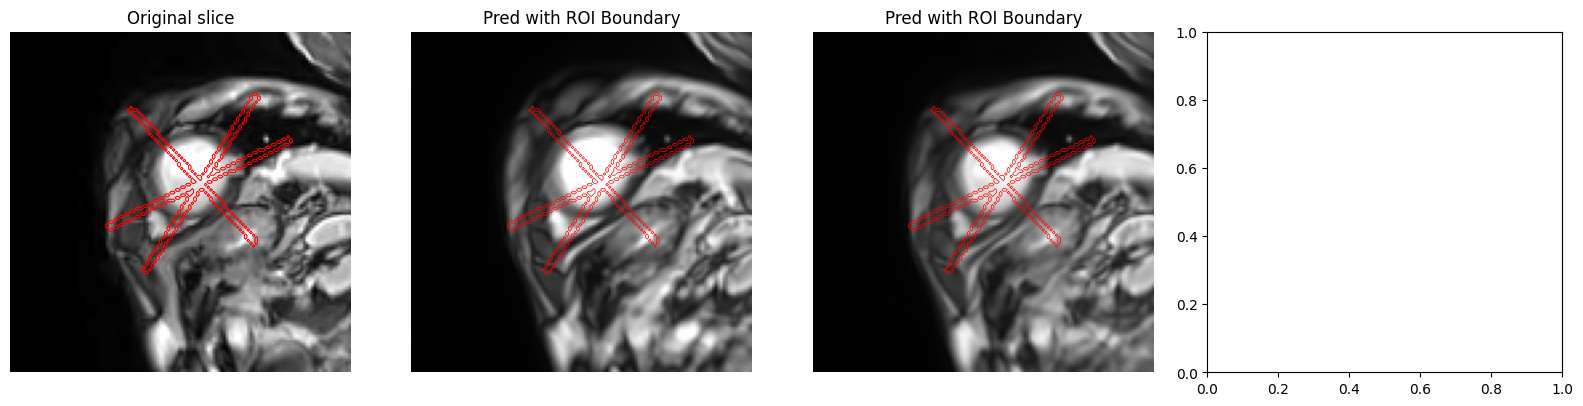

In [41]:
# SSIM, PSNR, 시각화 비교

from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# # vol_nz : -1~1
# # pred : 0~1
# i = 2
# pred_metric = model.render(xTs[i:i+1], cond=cond_tensor[i:i+1], T=t)
# pred_metric = pred_metric.squeeze(0).squeeze(0).detach().cpu().numpy()

original_sax = vol_nz[2, :, :]

pred_metric_opt = model.render(x_t_slice, cond = cond_slice, T=t)
pred_metric_opt = pred_metric_opt.squeeze(0).squeeze(0).detach().cpu().numpy()

pred_metric = model.render(x_t_slice_init, cond = cond_slice_init, T=t)
pred_metric = pred_metric.squeeze(0).squeeze(0).detach().cpu().numpy()


# vol_compare = 

# ssim_val_ = ssim(vol_compare, pred_metric, data_range=1.0)
# psnr_val_ = psnr(vol_compare, pred_metric, data_range=1.0)

# pred_metric_opt = pred.squeeze(0).squeeze(0).detach().cpu().numpy()
# ssim_val_opt = ssim(vol_compare, pred_metric_opt, data_range=1.0)
# psnr_val_opt = psnr(vol_compare, pred_metric_opt, data_range=1.0)

# print(f"ORIGINAL: {i}, ssim: {ssim_val_}, psnr: {psnr_val_}")
# print(f"OPTIMIZE: {i}, ssim: {ssim_val_opt}, psnr: {psnr_val_opt}")


mask_np = region_mask.detach().cpu().squeeze().numpy().astype(bool)
gt_np = gt.detach().cpu().squeeze().cpu().numpy()

# Compute statistics
pred_vals = pred_metric_opt[mask_np]
gt_vals = gt_np[mask_np]

stats = {
    'pred_mean': float(np.nanmean(pred_vals)),
    'pred_max': float(np.nanmax(pred_vals)),
    'pred_min': float(np.nanmin(pred_vals)),
    'gt_mean': float(np.nanmean(gt_vals)),
    'gt_max': float(np.nanmax(gt_vals)),
    'gt_min': float(np.nanmin(gt_vals))
}

# Visualize GT and Pred with ROI boundary
mask_edge = find_boundaries(mask_np, mode='outer')

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(gt_np, cmap='gray')
axs[0].contour(mask_edge, colors='r', linewidths=0.5)
axs[0].set_title('GT with ROI Boundary')
axs[0].axis('off')

axs[0].imshow(original_sax, cmap='gray')
axs[0].contour(mask_edge, colors='r', linewidths=0.5)
axs[0].set_title('Original slice')
axs[0].axis('off')

axs[1].imshow(pred_metric_opt, cmap='gray')
axs[1].contour(mask_edge, colors='r', linewidths=0.5)
axs[1].set_title('Pred with ROI Boundary')
axs[1].axis('off')

axs[2].imshow(pred_metric, cmap='gray')
axs[2].contour(mask_edge, colors='r', linewidths=0.5)
axs[2].set_title('Pred with ROI Boundary')
axs[2].axis('off')


# # 4) Figure 생성 및 시각화
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# axes[0].imshow(pred_metric, cmap='gray', vmin=0, vmax=1)
# axes[0].set_title('DiffAE')
# axes[0].axis('off')

# axes[1].imshow(vol_compare, cmap='gray', vmin=0, vmax=1)
# axes[1].set_title('Original')
# axes[1].axis('off')

# axes[2].imshow(pred_metric_opt, cmap='gray', vmin=0, vmax=1)
# axes[2].set_title('Optimize')
# axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
with torch.no_grad():
    # 초기(최적화 전) 예측
    orig_pred = model.render(x_t_slice_init, cond=cond_slice_init, T=t)
    # 최적화된 예측
    final_pred = model.render(x_t_slice,      cond=cond_slice,      T=t)

# NumPy 배열로 변환
orig_np  = orig_pred .squeeze(0).squeeze(0).cpu().numpy()  # shape=(H,W)
final_np = final_pred.squeeze(0).squeeze(0).cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
import torch
from skimage.segmentation import find_boundaries

# 1) 초기 pred 계산
with torch.no_grad():
    pred_init = model.render(x_t_slice_init, cond=cond_slice_init, T=t)  # (1, C, H, W)
pred_init_img = pred_init.squeeze().cpu().numpy()  # (H, W)


# 2) mask, gt numpy 변환
# mask_np = (mask.squeeze().cpu().numpy() > 0.5)  # bool (H, W)
gt_np   = region_gt.squeeze().cpu().numpy()            # float (H, W)


# # 3) ROI 영역의 GT 패치와 Pred 패치
# gt_patch   = gt_np * mask_np                    # GT에서 mask 영역만
# # pred_patch = pred_init_img * mask_np            # Pred에서 mask 영역만

# # 4) mask 윤곽선 추출
# mask_edge = find_boundaries(mask_np, mode='outer')  # bool (H, W)

# 5) 시각화
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# (a) 초기 예측 전체
axs[0].imshow(pred_init_img, cmap='gray')
axs[0].set_title('Initial Pred')
axs[0].axis('off')

# (b) ROI GT 패치만
axs[1].imshow(real_data, cmap='gray')
axs[1].set_title('GT Patch (ROI)')
axs[1].axis('off')

# (c) ROI Pred 패치만
axs[2].imshow(final_np, cmap='gray')
axs[2].set_title('Pred Patch (ROI)')
axs[2].axis('off')

# # (d) Initial Pred 위에 GT 패치 윤곽선
# axs[3].imshow(gt_np, cmap='gray')
# # axs[3].contour(mask_edge, colors='r', linewidths=1.0)
# axs[3].set_title('Pred + GT ROI Edge')
# axs[3].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 0) NumPy 배열 준비 (이미 계산해 두신 상태라고 가정) ---
# pred_init_img: (H, W) NumPy array
# real_data:    (H, W) NumPy array — region_gt 기반 ROI 패치
# final_np:     (H, W) NumPy array — 최종 pred 패치

# 예시: 만약 real_data가 torch.Tensor라면
# real_data_np = real_data.squeeze().cpu().numpy()

# --- 1) 저장할 폴더 만들기 ---
output_dir = "/workspace/storage/kjh/cardiac/DMCVR/test/output/4-6"                          # 저장할 폴더 경로
os.makedirs(output_dir, exist_ok=True)                # 폴더가 없으면 생성

# --- 2) 이미지로 저장 ---
# (a) 초기 예측 전체
plt.imsave(
    os.path.join(output_dir, "pred_init.png"),
    pred_init_img,
    cmap="gray",
    vmin=pred_init_img.min(), vmax=pred_init_img.max()
)

# (b) GT Patch (ROI)
plt.imsave(
    os.path.join(output_dir, "real_data.png"),
    real_data,
    cmap="gray",
    vmin=real_data.min(), vmax=real_data.max()
)

# (c) Pred Patch (ROI)
plt.imsave(
    os.path.join(output_dir, "final_pred.png"),
    final_np,
    cmap="gray",
    vmin=final_np.min(), vmax=final_np.max()
)

np.save(os.path.join(output_dir, "pred_init_img.npy"), pred_init_img)
np.save(os.path.join(output_dir, "real_data.npy"),    real_data)
np.save(os.path.join(output_dir, "final_pred.npy"),   final_np)

print(f"Saved individual .npy files to `{output_dir}`")

print(f"저장 완료: {output_dir} 폴더를 확인하세요.")


In [ ]:
# --- 3) 나란히 시각화 ---

overlay  = 0.1 * orig_np + 0.1 * final_np


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(orig_np,  cmap='gray')
axes[0].set_title('Before Optimization')
axes[0].axis('off')

axes[1].imshow(final_np, cmap='gray')
axes[1].set_title('After Optimization')
axes[1].axis('off')

axes[2].imshow(overlay, cmap='gray')
axes[2].set_title('Overlay (Original + Resampled)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# # --- 4) (선택) NIfTI 로도 저장하고 싶다면 ---
# out0 = sitk.GetImageFromArray(orig_np)
# out1 = sitk.GetImageFromArray(final_np)
# # 원본과 spacing/origin/direction 맞추기
# out0.SetSpacing(orig_sp); out1.SetSpacing(orig_sp)
# out0.SetOrigin(orig_orig); out1.SetOrigin(orig_orig)
# out0.SetDirection(orig_dir); out1.SetDirection(orig_dir)
# sitk.WriteImage(out0, 'slice_before_opt.nii.gz')
# sitk.WriteImage(out1, 'slice_after_opt.nii.gz')

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu, sobel

# # Assuming pred and gt are available as torch tensors (1,1,H,W)
# # Convert to numpy

# pred = model.render(x_t_slice_init, cond=cond_slice_init, T=t)
# gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)

# pred_np = pred.detach().cpu().squeeze().numpy()
# gt_np   = gt.detach().cpu().squeeze().numpy()

# # --- 실험 1: 이진화 (Otsu) ---
# th_p = threshold_otsu(pred_np)
# mask_p = pred_np > th_p

# # --- 실험 2: 경계 맵 (Sobel) ---
# edges_p = sobel(pred_np)
# edges_g = sobel(gt_np)

# # 시각화
# fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# # Row 1: 실험1
# axs[0,0].imshow(pred_np, cmap='gray')
# axs[0,0].set_title('Pred Image')
# axs[0,0].axis('off')

# axs[0,1].imshow(mask_p, cmap='gray')
# axs[0,1].set_title('Binary Mask (Otsu)')
# axs[0,1].axis('off')

# axs[0,2].hist(pred_np.ravel(), bins=50)
# axs[0,2].axvline(th_p, color='r')
# axs[0,2].set_title('Histogram & Threshold')

# # Row 2: 실험2
# axs[1,0].imshow(pred_np, cmap='gray')
# axs[1,0].set_title('Pred Image')
# axs[1,0].axis('off')

# axs[1,1].imshow(edges_p, cmap='gray')
# axs[1,1].set_title('Pred Edges (Sobel)')
# axs[1,1].axis('off')

# axs[1,2].imshow(edges_g, cmap='gray')
# axs[1,2].set_title('GT Edges (Sobel)')
# axs[1,2].axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
## 실험1
# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu
# from scipy.ndimage import distance_transform_edt

# # --- 하이퍼파라미터 ---
# num_epochs    = 300
# num_steps     = 1
# base_lr       = 2e-3
# # lambda_roi    = 5.0
# lambda_roi    = 5.0
# lambda_shape  = 1.0
# lambda_latent = 0.01
# alpha_proj    = 0.001

# # --- 초기 셋업 ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice       = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice      = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init  = x_t_slice.detach().clone()
# cond_slice_init = cond_slice.detach().clone()
# mask            = region_mask.unsqueeze(0).to(device)  # (1,1,H,W)
# gt              = region_gt  .unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)

# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# # --- GT distance map 미리 계산해 GPU에 올리기 ---
# gt_np     = gt.detach().cpu().squeeze().numpy()
# th_g      = threshold_otsu(gt_np)
# mask_g    = (gt_np > th_g)
# dt_g      = distance_transform_edt(mask_g)
# dt_g_t    = torch.from_numpy(dt_g).to(device).unsqueeze(0).unsqueeze(0)
# dt_g_t.requires_grad_(False)

# # --- Plot 셋업 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- 최적화 루프 ---
# for epoch in range(num_epochs):
#     # 한 step만 실행
#     pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,1,H,W)

#     # 1) intensity ROI loss
#     roi_loss = F.mse_loss(pred*mask, gt*mask, reduction='sum') / mask.sum()

#     # 2) pred distance map (CPU에서만)
#     with torch.no_grad():
#         p_np      = pred.detach().cpu().squeeze().numpy()
#         th_p      = threshold_otsu(p_np)
#         mask_p    = (p_np > th_p)
#         dt_p      = distance_transform_edt(mask_p)
#     dt_p_t = torch.from_numpy(dt_p).to(device).unsqueeze(0).unsqueeze(0)
#     dt_p_t.requires_grad_(False)

#     # 3) shape loss
#     shape_loss = F.l1_loss(dt_p_t, dt_g_t)

#     # 4) latent prior
#     latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
#     cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
#     prior_loss = lambda_latent * (latent_reg + cond_reg)

#     # 5) total loss
#     loss = lambda_roi * roi_loss + lambda_shape * shape_loss + prior_loss

#     # 6) backward & update
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # 7) projection
#     with torch.no_grad():
#         x_t_slice.data  = (1-alpha_proj)*x_t_slice.data  + alpha_proj*x_t_slice_init
#         cond_slice.data = (1-alpha_proj)*cond_slice.data + alpha_proj*cond_slice_init

#     # 8) logging & plot
#     loss_history.append(loss.item())
#     line.set_xdata(range(len(loss_history))); line.set_ydata(loss_history)
#     ax.relim(); ax.autoscale_view(); fig.canvas.draw(); fig.canvas.flush_events()
#     print(f"[Epoch {epoch+1}] loss={loss.item():.6f} "
#           f"(roi={roi_loss.item():.6f}, shape={shape_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     scheduler.step()

# print("Optimization 완료")
# 

In [ ]:
# # 실험 2 - 구조적 정보 이용(마 실패패)

# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.filters import sobel
# from scipy.ndimage import distance_transform_edt

# # --- 하이퍼파라미터 ---
# num_epochs    = 300
# num_steps     = 1
# base_lr       = 2e-3
# lambda_roi    = 0
# lambda_shape  = 4.0
# lambda_latent = 0.01
# alpha_proj    = 0.001

# # --- 초기 셋업 ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice       = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice      = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init  = x_t_slice.detach().clone()
# cond_slice_init = cond_slice.detach().clone()
# mask            = region_mask.unsqueeze(0).to(device)
# gt              = region_gt  .unsqueeze(0).unsqueeze(0).to(device)

# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# # --- GT edge + distance map 미리 계산 ---
# gt_np    = gt.detach().cpu().squeeze().numpy()
# edges_g  = sobel(gt_np) > 0.0
# dt_g_inv = distance_transform_edt(~edges_g)
# dt_g_t   = torch.from_numpy(dt_g_inv).to(device).unsqueeze(0).unsqueeze(0)
# dt_g_t.requires_grad_(False)

# # --- Plot 셋업 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- 최적화 루프 ---
# for epoch in range(num_epochs):
#     pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,1,H,W)

#     # 1) intensity ROI loss
#     roi_loss = F.mse_loss(pred*mask, gt*mask, reduction='sum') / mask.sum()

#     # 2) pred edge + distance (CPU에서)
#     with torch.no_grad():
#         p_np     = pred.detach().cpu().squeeze().numpy()
#         edges_p  = sobel(p_np) > 0.0
#         dt_p_inv = distance_transform_edt(~edges_p)
#     dt_p_t = torch.from_numpy(dt_p_inv).to(device).unsqueeze(0).unsqueeze(0)
#     dt_p_t.requires_grad_(False)

#     # 3) Chamfer‐style loss
#     #    dt_g_t[edges_p], dt_p_t[edges_g]
#     e_p_t = torch.from_numpy(edges_p).to(device).unsqueeze(0).unsqueeze(0) 
#     e_g_t = torch.from_numpy(edges_g).to(device).unsqueeze(0).unsqueeze(0) 
#     chamfer_loss = dt_g_t[e_p_t].mean() + dt_p_t[e_g_t].mean()

#     # 4) latent prior
#     latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
#     cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
#     prior_loss = lambda_latent * (latent_reg + cond_reg)

#     # 5) total loss
#     loss = lambda_roi * roi_loss + lambda_shape * chamfer_loss + prior_loss

#     # 6) backward & update
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # 7) projection
#     with torch.no_grad():
#         x_t_slice.data  = (1-alpha_proj)*x_t_slice.data  + alpha_proj*x_t_slice_init
#         cond_slice.data = (1-alpha_proj)*cond_slice.data + alpha_proj*cond_slice_init

#     # 8) logging & plot
#     loss_history.append(loss.item())
#     line.set_xdata(range(len(loss_history))); line.set_ydata(loss_history)
#     ax.relim(); ax.autoscale_view(); fig.canvas.draw(); fig.canvas.flush_events()
#     print(f"[Epoch {epoch+1}] loss={loss.item():.6f} "
#           f"(roi={roi_loss.item():.6f}, chamfer={chamfer_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     scheduler.step()

# print("Optimization 완료")


In [ ]:
# import matplotlib.pyplot as plt

# # --- 예시: 한 스텝에서 계산된 변수들 ---
# # pred      = model.render(x_t_slice, cond=cond_slice, T=t)          # (1,1,H,W)
# # mask      = region_mask.unsqueeze(0).unsqueeze(0).to(device)      # (1,1,H,W)
# # gt        = region_gt.unsqueeze(0).unsqueeze(0).to(device)        # (1,1,H,W)
# # replaced  = pred*(1-mask) + gt*mask                               # (1,1,H,W)
# # soft_mask = KF.gaussian_blur2d(mask.float(), (21,21), (7,7)).clamp(0,1)  # (1,1,H,W)
# # blended   = soft_mask*replaced + (1-soft_mask)*pred               # (1,1,H,W)

# # numpy 변환
# hard_mask_np  = mask    .squeeze().detach().cpu().numpy()  # (H,W)
# soft_mask_np  = soft_mask.squeeze().detach().cpu().numpy()
# replaced_np   = replaced.squeeze().detach().cpu().numpy()
# blended_np    = blended .squeeze().detach().cpu().numpy()

# # 시각화
# fig, axs = plt.subplots(1,4,figsize=(16,4))

# axs[0].imshow(hard_mask_np, cmap='gray')
# axs[0].set_title('Hard Mask')
# axs[0].axis('off')

# axs[1].imshow(soft_mask_np, cmap='gray')
# axs[1].set_title('Soft Mask')
# axs[1].axis('off')

# axs[2].imshow(replaced_np, cmap='gray')
# axs[2].set_title('Replaced (Hard ROI)')
# axs[2].axis('off')

# axs[3].imshow(blended_np, cmap='gray')
# axs[3].set_title('Blended Output')
# axs[3].axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
# # 1) 학습이 끝난 후, 최적화된 x_t_slice 및 cond_slice 준비되어 있다고 가정
# #    x_t_slice.requires_grad_(True) 로 학습하다가, 이제 inference 시에는 grad 꺼줍니다:
# x_t_slice = x_t_slice.detach()  
# cond_slice = cond_slice.detach()

# # 2) no_grad() 로 감싸고 render 호출
# with torch.no_grad():
#     final_pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,1,H,W)
#     # final_pred 은 [0,1] 범위로 정규화되어 있다고 가정

# # 3) NumPy array 로 변환
# img_np = final_pred.squeeze(0).squeeze(0).cpu().numpy()  # shape = (H, W)

# # 4-a) 화면에 바로 출력
# plt.figure(figsize=(5,5))
# plt.imshow(img_np, cmap='gray')
# plt.title('Optimized Slice')
# plt.axis('off')
# plt.show()

In [ ]:
# import torch

# # 1) 원본 render 저장
# orig_render = model.render

# # 2) 디버그용 래퍼 정의
# def debug_render(x_T, cond=None, T=None):
#     print("▶ [DBG] Enter render")
#     print("   grad_enabled:", torch.is_grad_enabled())
#     print("   x_T.requires_grad:", x_T.requires_grad)
#     print("   cond.requires_grad:" if cond is not None else "   no cond", 
#           cond.requires_grad if cond is not None else "")

#     # 호출 직전의 grad_fn
#     print("   x_T.grad_fn:", x_T.grad_fn)

#     # 실제 render 호출
#     out = orig_render(x_T, cond=cond, T=T)

#     # 호출 직후의 requires_grad / grad_fn
#     print("◀ [DBG] Exit render")
#     print("   out.requires_grad:", out.requires_grad)
#     print("   out.grad_fn:", out.grad_fn)
#     return out

# # 3) monkey-patch
# model.render = debug_render

# # 4) 메인 최적화 루프 (나머지는 그대로)
# for step in range(num_steps):
#     with torch.enable_grad():
#         print(f"\n== Step {step}/{num_steps} ==")
#         print("x_t_slice.requires_grad:", x_t_slice.requires_grad)
#         print("cond_slice.requires_grad:", cond_slice.requires_grad)

#         # A) encode_stochastic (필요하면 여기도 debug 붙일 수 있습니다)
#         xTs = model.encode_stochastic(img_tensor, cond_tensor, T=t)

#         # B) 보간 및 x_t_slice 준비
#         # ... 기존 보간 / slice 선택 코드 ...

#         # C) debug_render 호출
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)

#         # D) mask / gt 준비
#         mask = region_mask.unsqueeze(0).to(device)       # (1,1,128,128)
#         gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)

#         print("pred shape:", pred.shape)
#         print("pred.requires_grad:", pred.requires_grad, "pred.grad_fn:", pred.grad_fn)

#         loss = F.mse_loss(pred * mask, gt * mask)
#         print("loss:", loss.item(), "loss.grad_fn:", loss.grad_fn)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
